In [1]:
# Dependencias.
import scipy.io

%matplotlib widget
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import probeinterface as pi
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.sorters as ss
import spikeinterface.exporters as exp
import seaborn as sns # <- Para graficos estadisticos
from preprocessing_functions import read_rhd, get_recording, check_concatenation, process_artifacts, espigas, sorting_analyzer, create_folders

from pathlib import Path
from spikeinterface.extractors import read_intan
import spikeinterface.preprocessing as prep
from probeinterface import Probe, ProbeGroup

15:07:22 [I] klustakwik KlustaKwik2 version 0.2.6


In [2]:
# global kwargs for parallel computing
job_kwargs = dict(
    n_jobs=-1,
    chunk_duration='1s',
    progress_bar=True,
)

si.set_global_job_kwargs(**job_kwargs)

## Lectura y Preprocesado.
el procesado de datos se realiza de la siguiente forma:  
```mermaid
flowchart TD
    A["Datos crudos (Raw)"] --> B["Filtro pasa banda (500 - 9000Hz)"]
    B --> C["Incorporacion de electrodos y definición de grupos"]
    C --> D["Definición de canales malos"]
    D --> E["Remoción de artefactos"]
    E --> F["`Guardado en formato binario (carpeta **preprocess**)`"]
    
```
Algunas opciones comunes de group_mode en SpikeInterface incluyen:

by_probe: Agrupa los canales o unidades según el probe (sonda) al que pertenecen. Esto es útil si se están utilizando varias sondas en el experimento.

by_shank: Agrupa los canales según el shank (tallo) dentro de un probe. Esto se usa cuando un probe tiene múltiples shanks.

by_electrode_group: Agrupa los canales por el grupo de electrodos. Esto permite analizar o procesar datos por grupos predefinidos de electrodos.

by_channel: Trata cada canal por separado, sin agruparlos. Es útil cuando se quiere analizar cada canal de manera independiente.

by_unit: Agrupa los datos según unidades individuales de spikes. Esto es útil cuando se quiere analizar características a nivel de unidades de spikes individuales en lugar de a nivel de canales.

all: Agrupa todos los canales o unidades en un solo grupo, tratándolos como un conjunto único. Esto puede ser útil para obtener un análisis global del conjunto de datos.

### Defición de parametros.
para el ejemplo, se almacenan todos los pasos intermedios, estos 

In [ ]:
# Configuración de archivos
probegroup_file = 'probes/anillo_probe.json'  # Archivo de configuración del probegroup

# Configuración de carpetas de procesamiento
preprocess_folder = Path('preprocess/')

# Archivos de Excel para la información de registros
# como inicio se recomienda solo poner un dia en el excel de información de archivos, este es el punto de inicio para hacer una maquina de salchichas para todos los días del animal
excel_file_maze = r'C:\Users\Labcn\OneDrive - Universidad Católica de Chile\sorting_anillo\input_files\PF07\Maze\informacion_archivos.xlsx'
excel_file_sleep = r'C:\Users\Labcn\OneDrive - Universidad Católica de Chile\sorting_anillo\input_files\PF07\Sleep\informacion_archivos.xlsx'

In [3]:
# Configuración de archivos
probegroup_file = 'probes/TM24_probe.json'  # Archivo de configuración del probegroup

# Configuración de carpetas de procesamiento
preprocess_folder = Path('preprocess/')

# Archivos de Excel para la información de registros
# como inicio se recomienda solo poner un dia en el excel de información de archivos, este es el punto de inicio para hacer una maquina de salchichas para todos los días del animal
excel_file_maze = r'C:\Users\Labcn\OneDrive - Universidad Católica de Chile\Datos_Ariel\TM24\TM24_td3\informacion_archivos.xlsx'
excel_file_sleep = r'C:\Users\Labcn\OneDrive - Universidad Católica de Chile\Datos_Ariel\TM24\TM24_sd3\informacion_archivos.xlsx'

In [4]:
# Procesar archivos
record_maze = get_recording(excel_file_maze, probegroup_file)
record_sleep = get_recording(excel_file_sleep, probegroup_file)
recording = check_concatenation(record_maze, record_sleep)

# Crear carpeta para picos para sorting manual si es necesario
peak_folder = Path('output/manual/peaks')
# peak_folder.mkdir(exist_ok=True)

Concatenados 6 archivos .rhd.
No se encontró ningún archivo LAN en el directorio especificado.
Se omite la remoción de artefactos
Solo un registro disponible para concatenar.
Procesamiento de archivos completado
Concatenados 18 archivos .rhd.
No se encontró ningún archivo LAN en el directorio especificado.
Se omite la remoción de artefactos
Solo un registro disponible para concatenar.
Procesamiento de archivos completado
Registros de Maze y Sueño concatenados exitosamente.


### Inspeccion de los resultados.
Revise:
Se haya realizado el procedimiento de concatenado.
Se removieron los artefactos.
Nombres de los canales.

importante: Con el fin de mejorar la visualización, los datos no estan escalados. Para presentarlos escalados (uV) defina return_scaled=True

In [5]:
recording

ConcatenateSegmentRecording: 64 channels - 20.0kHz - 1 segments - 165,742,560 samples 
                             8,287.13s (2.30 hours) - int16 dtype - 19.76 GiB

In [7]:
# plot and check spikes
mode = "line"
w = sw.plot_traces(recording=recording,  
                   mode=mode, time_range=(0, 105), color_groups=True, return_scaled=False,
                  show_channel_ids=True, order_channel_by_depth=False, backend="ephyviewer")

recording

ConcatenateSegmentRecording: 64 channels - 20.0kHz - 1 segments - 165,742,560 samples 
                             8,287.13s (2.30 hours) - int16 dtype - 19.76 GiB

### Eliminacion de canales.
indique los canales a eliminar, para ello utilice el nombre ("Channel ID") que se le da en Intan. Observe el ejemplo.
Confirme que se haya realizado la eliminación ejecutando la celda anterior.

In [ ]:
bad_channels =["A-015", "A-016"]
recording=recording.remove_channels(bad_channels)


### Guardar archivos preprocesados
Guardar archivos preprocesados como binarios.

#### Guardar el registro completo

In [ ]:
recording.save(folder=preprocess_folder, overwrite=True, **job_kwargs)
    # rec_artifacts.save(folder=preprocess_artifacts, **job_kwargs) # ejercicio para guardar registro sin la eliminaciòn de artefactos.

#### Guardar un segmento del registro

In [ ]:
sliced_rec=recording.time_slice(start_time=0, end_time=2000)
sliced_rec.save(format='binary', folder=Path('preprocess/slic3d'), overwrite=True, **job_kwargs)

#### Leer el registro guardado

In [ ]:
recording = si.load_extractor(preprocess_folder)

## Estimar ruido

Estimate noise for each channel using MAD methods (median absolute deviation). You can use standard deviation with method=”std”
Internally it samples some chunk across segment. And then, it use MAD estimator (more robust than STD)

detalle para el calculo de chunks
```python
   random_chunks = get_random_data_chunks(recording, return_scaled=return_scaled, **random_chunk_kwargs)
```
   
detalle del codigo para calcular el ruido:
```python
    if method == "mad":
        med = np.median(random_chunks, axis=0, keepdims=True)
        # hard-coded so that core doesn't depend on scipy
        noise_levels = np.median(np.abs(random_chunks - med), axis=0) / 0.6744897501960817
```
        
ref, API: https://github.com/SpikeInterface/spikeinterface/blob/a9b4c34200be91a589ad145c976c5a177ce6746e/src/spikeinterface/core/recording_tools.py#L82C5-L100

interesante discusión en:
https://github.com/SpikeInterface/spikeinterface/issues/1681

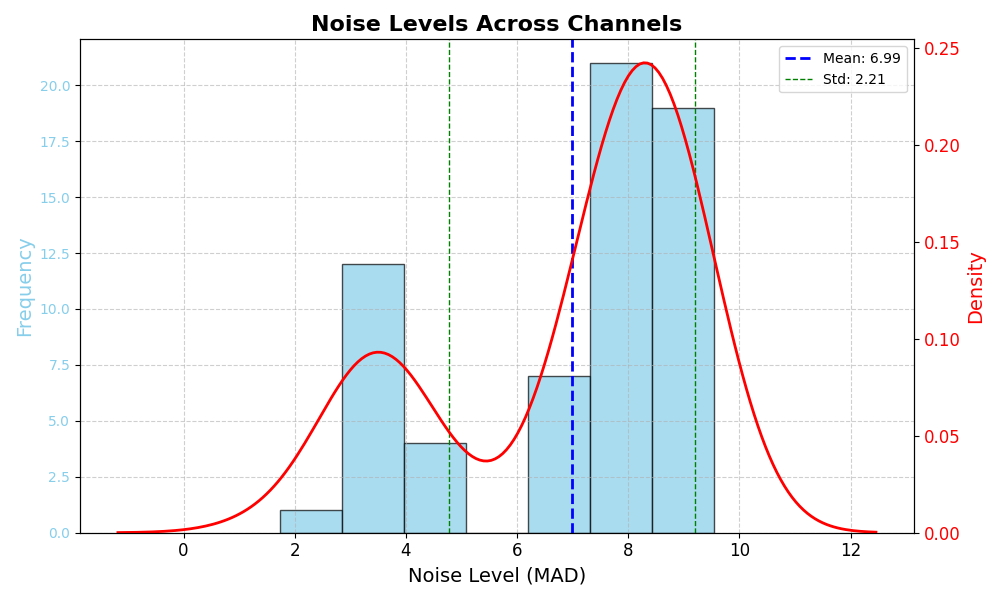

array([4.047504 , 4.3366113, 4.9148264, 4.047504 , 8.384115 , 8.673223 ,
       7.8059006, 8.384115 , 9.251438 , 9.251438 , 9.540545 , 8.96233  ,
       9.251438 , 8.96233  , 8.96233  , 8.96233  , 3.7583964, 8.673223 ,
       9.251438 , 8.673223 , 8.384115 , 8.96233  , 8.384115 , 8.384115 ,
       3.1801817, 3.469289 , 3.469289 , 3.1801817, 7.8059006, 8.095008 ,
       8.095008 , 8.095008 , 8.96233  , 8.673223 , 8.673223 , 8.96233  ,
       3.469289 , 3.469289 , 3.1801817, 2.8910742, 1.7346445, 7.8059006,
       7.8059006, 7.516793 , 7.8059006, 7.8059006, 7.8059006, 3.469289 ,
       7.227686 , 7.227686 , 7.516793 , 7.227686 , 7.227686 , 8.095008 ,
       8.095008 , 3.469289 , 7.8059006, 8.673223 , 8.384115 , 8.673223 ,
       3.1801817, 7.227686 , 6.938578 , 6.938578 ], dtype=float32)

In [8]:

# Calcular los niveles de ruido
noise_levels = si.get_noise_levels(recording, return_scaled=True, method="mad")

# Crear una figura más grande
fig, ax1 = plt.subplots(figsize=(10, 6))

# Histograma en el primer eje (ax1)
color_hist = 'skyblue'
ax1.hist(noise_levels, bins='auto', color=color_hist, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Noise Level (MAD)', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14, color=color_hist)
ax1.tick_params(axis='y', labelcolor=color_hist)

# Calcular y agregar línea vertical para la media en el primer eje
mean_noise = np.mean(noise_levels)
ax1.axvline(mean_noise, color='blue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_noise:.2f}')

# Calcular y agregar línea para la desviación estándar en el primer eje
std_noise = np.std(noise_levels)
ax1.axvline(mean_noise + std_noise, color='green', linestyle='dashed', linewidth=1, label=f'Std: {std_noise:.2f}')
ax1.axvline(mean_noise - std_noise, color='green', linestyle='dashed', linewidth=1)

# Agregar leyenda al primer eje
ax1.legend()

# Crear el segundo eje para la densidad (ax2) que comparte el mismo eje x
ax2 = ax1.twinx()
color_density = 'red'

# Agregar línea de densidad con seaborn en el segundo eje
sns.kdeplot(noise_levels, color=color_density, linewidth=2, ax=ax2)
ax2.set_ylabel('Density', fontsize=14, color=color_density)
ax2.tick_params(axis='y', labelcolor=color_density)

# Agregar título principal
plt.title('Noise Levels Across Channels', fontsize=16, fontweight='bold')

# Mejorar los ticks del eje x
ax1.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

# Agregar gridlines para mayor claridad
ax1.grid(True, linestyle='--', alpha=0.6)

# Ajustar el layout para evitar que se superpongan elementos
plt.tight_layout()

# Mostrar la gráfica
plt.show()
noise_levels

## Detectar peaks
La detección de peaks suele ser el primer paso en la clasificación de señales y consiste en encontrar peaks en los registros que podrían ser spikes reales.”

Different methods are available with the method argument:

‘by_channel’ (default): peaks are detected separately for each channel
‘locally_exclusive’ (requires numba): peaks on neighboring channels within a certain radius are excluded (not counted multiple times)
‘by_channel_torch’ (requires torch): pytorch implementation (GPU-compatible) that uses max pooling for time deduplication
‘locally_exclusive_torch’ (requires torch): pytorch implementation (GPU-compatible) that uses max pooling for space-time deduplication

**si quiere cambiar el método, debes eliminar el archivo peaks.npy antes de calcular**

[lista de parametros API](https://spikeinterface.readthedocs.io/en/latest/api.html#spikeinterface.sortingcomponents.peak_detection.detect_peaks)  
referencias sobre el paso de [deteccion de espigas](https://spikeinterface.readthedocs.io/en/latest/modules/sortingcomponents.html#peak-detection)

In [ ]:
peak_folder = Path('output/manual/peaks')
peak_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
if not (peak_folder / 'peaks.npy').exists():
    peaks = detect_peaks(
        recording=recording,
        method='locally_exclusive',
        peak_sign='neg',
        detect_threshold=5, # Threshold, in median absolute deviations (MAD), to use to detect peaks
        noise_levels=noise_levels,
        **job_kwargs,
    )
    np.save(peak_folder / 'peaks.npy', peaks)
peaks = np.load(peak_folder / 'peaks.npy')
print("cantidad de eventos:", peaks.shape)
print("Tipo de peaks:", type(peaks))
print("Contenido de peaks:", peaks)
print("Tipo de datos en peaks:", peaks.dtype)

In [ ]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

# método centro de masas con largo 0.9s, 0.3 antes y 0.6 despues

if not (peak_folder / 'peak_locations_center_of_mass.npy').exists():
    peak_locations = localize_peaks(
        recording=rec_fil,
        peaks=peaks,
        ms_before=0.3,
        ms_after=0.6,
        method='center_of_mass',
        **job_kwargs,
    )
    np.save(peak_folder / 'peak_locations_center_of_mass.npy', peak_locations)
    print(peak_locations.shape)

In [ ]:
# método monopolar_triangulation

if not (peak_folder / 'peak_locations_monopolar_triangulation_legacy.npy').exists():
    peak_locations = localize_peaks(
        recording=rec_fil,
        peaks=peaks,
        ms_before=0.3,
        ms_after=0.6,
        method='monopolar_triangulation',
        **job_kwargs,
    )
    np.save(peak_folder / 'peak_locations_monopolar_triangulation_legacy.npy', peak_locations)
    print(peak_locations.shape)

## Ejecutar un sorter
ejecutar Kilosort

### revisar parametros de entrada (configuracion)
parametros especificos para kilosort (pasables por kwargs):  
https://kilosort.readthedocs.io/en/latest/parameters.html  
https://github.com/MouseLand/Kilosort/blob/main/kilosort/parameters.py

In [9]:
# limpiar la memoria de torch antes de procesar el sorter.
import torch
torch.cuda.empty_cache()

ss.get_default_sorter_params('kilosort4')

{'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'do_CAR': True,
 'invert_sign': False,
 'nt': 61,
 'shift': None,
 'scale': None,
 'artifact_threshold': None,
 'nskip': 25,
 'whitening_range': 32,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': None,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'cluster_pcs': 64,
 'x_centers': None,
 'duplicate_spike_ms': 1.5,
 'do_correction': True,
 'keep_good_only': False,
 'save_extra_kwargs': False,
 'skip_kilosort_preprocessing': False,
 'scaleproc': None,
 'torch_device': 'auto'}

## Kilosort 4

In [ ]:
from pathlib import Path
base_name = 'TM24_1'

# Single sorting
sorter_folder, analyzer_folder, phy_output_folder = create_folders(base_name)

# Group sorting
group_sorter_folder, group_analyzer_folder, group_phy_output_folder = create_folders(base_name, group=True)


In [ ]:
params_kilosort4 = {## MAIN_PARAMETERS 
                    'batch_size': 30000,
                    'nblocks': 0,
                    'Th_universal': 9,
                    'Th_learned': 8,
                    ## Preprocessing
                    'artifact_threshold': 1000,
                    ## SPIKE DETECTION
                    'min_template_size': 10,
                    'template_sizes':5,
                    'nearest_chans': 4,
                    'nearest_templates': 15,
                    'max_channel_distance': 60,
                    'templates_from_data': True,   
                    'n_pcs':6,
                    'Th_single_ch': 6,
                    ## Clustering
                        #'acg_threshold':0.15,
                        #'cluster_downsampling':10,
                    ## extras
                        #'binning_depth':4,
                        #'drift_smoothing':[0.3, 0.3, 0.3],
                    'skip_kilosort_preprocessing': False,} # se crea un diccionario donde se pueden pasar las variables modificadas al sorter.

### Sorting en bulto

In [ ]:
sorter = ss.run_sorter(
                sorter_name='kilosort4',
                recording = recording,
                verbose=True,
                folder = sorter_folder,
                remove_existing_folder=True,  ## CUIDADO, SOBREESCRIBE LOS DATOS EN CASO DE HABER UNA CARPETA, PARA DESHABILITAR PONER =FALSE
                **params_kilosort4)

num_clusters, total_spikes= espigas(sorter)
print(f"Número total de clusters: {num_clusters}")
print(f"Número total de espigas: {total_spikes}")

analyzer=sorting_analyzer(sorter, recording, output_folder=analyzer_folder)

exp.export_to_phy(sorting_analyzer=analyzer, 
                  remove_if_exists=True, 
                  copy_binary=True, 
                  output_folder=phy_output_folder)

### Sorting por grupo : Automatic splitting

In [ ]:
group_sorter = ss.run_sorter_by_property(
                sorter_name='kilosort4',
                recording = recording,
                grouping_property='group',
                verbose=True,
                folder = group_sorter_folder,
                remove_existing_folder=True,  ## CUIDADO, SOBREESCRIBE LOS DATOS EN CASO DE HABER UNA CARPETA, PARA DESHABILITAR PONER =FALSE
                **params_kilosort4)

num_clusters, total_spikes= espigas(group_sorter)
print(f"Número total de clusters: {num_clusters}")
print(f"Número total de espigas: {total_spikes}")

group_analyzer=sorting_analyzer(group_sorter, recording, output_folder=group_analyzer_folder)

exp.export_to_phy(sorting_analyzer=group_analyzer, 
                  remove_if_exists=True, 
                  copy_binary=True, 
                  output_folder=group_phy_output_folder) 

### Sorting por grupo : Manual splitting (en desarrollo)

El enfoque implementado tiene como objetivo mejorar el rendimiento del spike sorting al segmentar el proceso por grupos de canales o regiones de la grabación. Al realizar el spike sorting por partes, se reduce significativamente la demanda de memoria y el uso de GPU en cada ejecución. Esto es especialmente útil cuando se trabaja con grabaciones de gran tamaño o cuando la capacidad de la GPU es limitada.

Dividiendo el registro en grupos, el sorter puede operar en fragmentos más pequeños, lo que permite manejar mejor los recursos del sistema y evitar problemas como errores de "out of memory" (falta de memoria). Después de realizar el spike sorting por grupos, los resultados se combinan, permitiendo un análisis y exportación global sin sacrificar la eficiencia durante el proceso de clasificación inicial.

Este enfoque balancea el uso de recursos, optimizando el uso de la GPU sin comprometer la calidad del análisis final.

In [ ]:
# Dividir la grabación por grupos
split_recording = recording.split_by("group")

# Diccionario para almacenar los resultados de sorting por grupo
sortings = {}

# Ejecutar el sorter en cada grupo
for group, sub_recording in split_recording.items():
    sorting = run_sorter(
        sorter_name='kilosort4',
        recording=sub_recording,  # Usar la subgrabación del grupo
        output_folder=f"fKS4_group{group}"
    )
    sortings[group] = sorting  # Almacenar los resultados del sorter para este grupo

# Combinar los resultados de sorting de todos los grupos
combined_sorting = si.concatenate_sortings(*sortings.values())

# Información de clusters y espigas para cada grupo
num_clusters, total_spikes = espigas(combined_sorting)
print(f"  Número total de clusters: {num_clusters}")
print(f"  Número total de espigas: {total_spikes}")

# Realizar análisis global con el sorting combinado
combined_analyzer = sorting_analyzer(combined_sorting, recording, output_folder='combined_analyzer_folder')

# Exportar los resultados globales a Phy
exp.export_to_phy(sorting=combined_analyzer,  # Sorting combinado
                  recording=recording,        # Grabación completa
                  remove_if_exists=True,
                  copy_binary=True,
                  output_folder='combined_phy_output_folder')


## inspeccion en grafico

### leer un analisis

In [ ]:

folder = 'output/AN/kilosort/analyzer_Rev9'
analyzer = si.load_sorting_analyzer(folder)

In [ ]:
exp.export_to_phy(sorting_analyzer=analyzer, 
                  remove_if_exists=True, 
                  copy_binary=True, 
                  output_folder=Path('output/AN/kilosort/phy_rev9v2'))

In [ ]:
import spikeinterface.widgets as sw

sw.plot_spikes_on_traces(sorting_analyzer= analyzer, 
                         segment_index=None, 
                         channel_ids=None, 
                         unit_ids=None, 
                         order_channel_by_depth=False, 
                         time_range=None, 
                         unit_colors=None, 
                         sparsity=None, 
                         mode='auto', 
                         return_scaled=False, 
                         cmap='RdBu', 
                         show_channel_ids=False, 
                         color_groups=False, 
                         color=None, 
                         clim=None, 
                         tile_size=512, 
                         seconds_per_row=0.2, 
                         scale=1, 
                         spike_width_ms=4, 
                         spike_height_um=20, 
                         with_colorbar=True, 
                         backend="ipywidgets")


## Unit quality metrics

In [ ]:
from spikeinterface.postprocessing import compute_principal_components
from spikeinterface.qualitymetrics import compute_quality_metrics, get_quality_metric_list

In [ ]:
get_quality_metric_list()

In [ ]:
metrics = compute_quality_metrics(analyzer, metric_names=["snr", "isi_violation", "nearest_neighbor", "firing_rate", 'presence_ratio', 'amplitude_cutoff'])

In [ ]:
print (metrics)

In [ ]:
keep_mask = (metrics["amplitude_cutoff"] < 1e-6)
print(keep_mask)

In [ ]:
keep_unit_ids = keep_mask[keep_mask].index.values
keep_unit_ids = [unit_id for unit_id in keep_unit_ids]
print(keep_unit_ids)

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d
plt.rcParams.update({'font.size': 14})

def plot_metric(data, bins, x_axis_label, color, max_value=-1):
    
    h, b = np.histogram(data, bins=bins, density=True)

    x = b[:-1]
    y = gaussian_filter1d(h, 1)

    plt.plot(x, y, color=color)
    plt.xlabel(x_axis_label)
    plt.gca().get_yaxis().set_visible(False)
    [plt.gca().spines[loc].set_visible(False) for loc in ['right', 'top', 'left']]
    if max_value < np.max(y) * 1.1:
        max_value = np.max(y) * 1.1
    plt.ylim([0, max_value])
    
    return max_value

In [ ]:
ss.get_default_sorter_params('spykingcircus2')


In [ ]:
sorter_spykingcircus2 = ss.run_sorter(
                sorter_name='spykingcircus2',
                recording = rec_fil,
                verbose=True,
                folder = 'output/spykingcircus2',
                remove_existing_folder=True  ## CUIDADO, SOBREESCRIBE LOS DATOS EN CASO DE HABER UNA CARPETA, PARA DESHABILITAR PONER =FALSE
                )